In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

import statsmodels.formula.api as smf
import lxml

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:.4f}'.format

In [3]:
data = pd.read_csv('../raw_data/dreaddit-train.csv', parse_dates=True)
data_test = pd.read_csv('../raw_data/dreaddit-test.csv', parse_dates=True)

In [4]:
#data.columns.to_list()
cols_to_remove =  ['syntax_ari',
                   'syntax_fk_grade',
                   'lex_dal_max_pleasantness',
                   'lex_dal_max_activation',
                   'lex_dal_max_imagery',
                   'lex_dal_min_pleasantness',
                   'lex_dal_min_activation',
                   'lex_dal_min_imagery',
                   'lex_dal_avg_activation',
                   'lex_dal_avg_imagery',
                   'lex_dal_avg_pleasantness',
                   'sentiment',
                   'post_id']
data.drop(columns=cols_to_remove, inplace=True)

In [5]:
data['domain'] = data['subreddit'].map({'domesticviolence': 'abuse',
                                       'survivorsofabuse': 'abuse',
                                       'anxiety': 'anxiety',
                                       'stress': 'anxiety',
                                       'almosthomeless': 'ﬁnancial',
                                       'assistance': 'ﬁnancial',
                                       'food_pantry': 'ﬁnancial',
                                       'homeless':'ﬁnancial',
                                       'ptsd':'ptsd',
                                       'relationships':'social'
                                       })

In [6]:
data.isnull().sum().sort_values(ascending=True)
#no missing values in the data set

subreddit               0
lex_liwc_space          0
lex_liwc_motion         0
lex_liwc_relativ        0
lex_liwc_focusfuture    0
                       ..
lex_liwc_conj           0
lex_liwc_adverb         0
lex_liwc_auxverb        0
social_num_comments     0
domain                  0
Length: 104, dtype: int64

In [7]:
data.dtypes

subreddit               object
sentence_range          object
text                    object
id                       int64
label                    int64
                        ...   
lex_liwc_Parenth       float64
lex_liwc_OtherP        float64
social_upvote_ratio    float64
social_num_comments      int64
domain                  object
Length: 104, dtype: object

In [8]:
data['social_date'] = data['social_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data = data.drop(columns='social_timestamp')

#### check distribution of characters within each Reddit post

In [23]:
#data[data['text'].apply(lambda x: len(x)<35)]

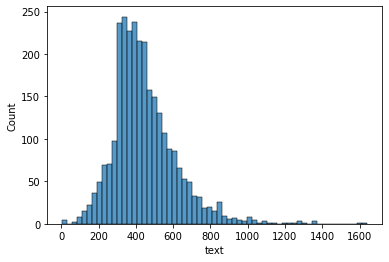

In [9]:
sns.histplot(data['text'].apply(lambda x: len(x)));

In [10]:
rows_to_remove = data['text'].apply(lambda x: len(x)).sort_values().head(5).index.to_list()
data.iloc[rows_to_remove]

,subreddit,sentence_range,text,id,label,confidence,social_karma,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,...,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,social_upvote_ratio,social_num_comments,domain,social_date
1592,anxiety,"[15, 20]",#NAME?,469,1,0.571429,3,9,74.89,13.32,4.97,1.0,9.0,44.44,100.00,11.11,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,11.11,0.00,11.11,0.00,0.00,0.0,0.00,11.11,0.00,11.11,0.00,0.00,11.11,0.00,0.00,0.00,0.00,0.00,11.11,11.11,0.00,...,22.22,0.00,0.00,22.22,44.44,11.11,11.11,0.0,22.22,11.11,0.00,11.11,0.00,0.00,11.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.11,0.0,0.0,0.0,0.0,0.0,0.0,55.56,0.00,0.00,0.0,0.0,0.0,0.0,55.56,0.0,0.00,0.0,0.0,1.00,7,anxiety,2018-01-28 04:36:40
295,domesticviolence,"(10, 15)",#NAME?,31315,0,0.800000,10,78,39.13,99.00,46.75,99.0,15.6,16.67,92.31,62.82,25.64,16.67,3.85,2.56,10.26,0.00,0.0,8.97,1.28,17.95,6.41,1.28,10.26,0.00,15.38,3.85,3.85,2.56,0.0,1.28,12.82,12.82,0.00,0.00,0.00,0.00,19.23,0.00,0.00,0.00,0.00,6.41,1.28,1.28,...,2.56,0.00,2.56,0.00,1.28,1.28,0.00,0.0,0.00,14.10,3.85,5.13,5.13,2.56,0.00,2.56,11.54,2.56,14.10,2.56,7.69,3.85,2.56,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.38,6.41,3.85,0.0,0.0,0.0,0.0,5.13,0.0,0.00,0.0,0.0,0.92,9,abuse,2017-12-08 09:21:17
2190,ptsd,"[30, 35]",#NAME?,559,1,1.000000,9,35,16.23,38.74,98.59,1.0,35.0,34.29,94.29,54.29,20.00,14.29,14.29,0.00,0.00,0.00,0.0,5.71,8.57,8.57,8.57,11.43,8.57,2.86,17.14,2.86,0.00,5.71,0.0,0.00,14.29,0.00,14.29,5.71,0.00,2.86,14.29,8.57,2.86,2.86,5.71,11.43,8.57,0.00,...,2.86,0.00,0.00,2.86,0.00,0.00,0.00,0.0,0.00,20.00,11.43,0.00,2.86,0.00,5.71,5.71,8.57,0.00,11.43,0.00,2.86,8.57,0.00,2.86,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,20.00,0.00,0.00,0.0,0.0,0.0,0.0,14.29,0.0,5.71,0.0,0.0,0.85,9,ptsd,2018-11-06 22:25:11
2563,domesticviolence,"(15, 20)",#NAME?,29201,0,0.800000,23,92,4.30,99.00,1.00,99.0,18.4,15.22,96.74,60.87,23.91,19.57,0.00,0.00,7.61,11.96,0.0,4.35,1.09,9.78,11.96,8.70,10.87,0.00,20.65,6.52,3.26,5.43,0.0,1.09,14.13,10.87,3.26,0.00,2.17,0.00,30.43,1.09,0.00,1.09,11.96,15.22,4.35,1.09,...,8.70,5.43,1.09,2.17,1.09,0.00,1.09,0.0,0.00,6.52,2.17,2.17,1.09,3.26,0.00,0.00,13.04,8.70,11.96,0.00,5.43,6.52,0.00,1.09,1.09,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,13.04,5.43,3.26,0.0,0.0,0.0,0.0,4.35,0.0,0.00,0.0,0.0,1.00,4,abuse,2018-05-25 13:55:30
854,assistance,"[10, 15]",<url> Resume: <url> Thank you! !,806,0,0.571429,16,5,51.43,99.00,1.00,99.0,5.0,0.00,60.00,20.00,20.00,20.00,0.00,0.00,20.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.0,0.00,20.00,20.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0

In [10]:
data.shape

(2838, 104)

In [11]:
data.drop(labels=rows_to_remove, inplace=True )
data.shape

(2833, 104)

In [12]:
data['pct_caps'] = data['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x) )
data['text'] = data['text'].apply(lambda x: x.lower())

#### comparison on Naive Bayes using TF-iDF vs. LIWC vectorizer

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data['text'])

y = data['label']

nb_model = MultinomialNB()

nb_model.fit(X,y)


MultinomialNB()

In [14]:
data_test.drop(columns=cols_to_remove, inplace=True)

data_test['domain'] = data_test['subreddit'].map({'domesticviolence': 'abuse',
                                                   'survivorsofabuse': 'abuse',
                                                   'anxiety': 'anxiety',
                                                   'stress': 'anxiety',
                                                   'almosthomeless': 'ﬁnancial',
                                                   'assistance': 'ﬁnancial',
                                                   'food_pantry': 'ﬁnancial',
                                                   'homeless':'ﬁnancial',
                                                   'ptsd':'ptsd',
                                                   'relationships':'social'
                                                   })

data_test['social_date'] = data_test['social_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_test = data_test.drop(columns='social_timestamp')

data_test['pct_caps'] = data_test['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x) )
data_test['text'] = data_test['text'].apply(lambda x: x.lower())

In [15]:
y_test = data_test['label']

X_test = vectorizer.transform(data_test['text'])

nb_model.score(X_test,y_test)

0.6461538461538462

In [16]:
non_liwc_cols = ['subreddit', 
                 'sentence_range', 
                 'text', 
                 'id', 
                 'label', 
                 'confidence', 
                 'social_karma', 
                 'social_upvote_ratio',
                 'social_num_comments', 
                 'domain', 
                 'social_date',
                 'pct_caps']

X_liwc = data.drop(columns=non_liwc_cols) 
nb_model1 = MultinomialNB()
nb_model1.fit(X_liwc,y)

MultinomialNB()

In [17]:
X_liwc_test = data_test.drop(columns=non_liwc_cols)
nb_model1.score(X_liwc_test,y_test)

0.7412587412587412

In [18]:
log_reg_drop =  ['subreddit', 
                 'sentence_range', 
                 'text', 
                 'id', 
                 'label', 
                 'confidence',
                 'social_date',
                 'domain']
log_reg_X = data.drop(columns= log_reg_drop)

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10_000)

log_reg.fit(X=X_liwc, y=data['label'], sample_weight=data['confidence'])

LogisticRegression(max_iter=10000)

In [20]:
log_reg.score(X_liwc_test,y_test)

0.7426573426573426

In [21]:
log_reg1 = LogisticRegression(max_iter=10_000)

log_reg1.fit(X=log_reg_X, y=data['label'], sample_weight=data['confidence'])

LogisticRegression(max_iter=10000)

In [22]:
log_reg_X_test = data_test.drop(columns=log_reg_drop)
log_reg1.score(log_reg_X_test,y_test)

0.7468531468531469

## Feature Selection

In [23]:
data.shape

(2833, 105)

In [24]:
data['id'].nunique()
data.set_index('id',inplace=True)

In [25]:
data['domain_label'] = data['domain'].map({'ptsd':1,
                                           'ﬁnancial':2,
                                           'social':3,
                                           'abuse':4,
                                           'anxiety':5
                                            })



In [26]:
eda_data = data.drop(columns=['text','subreddit','domain'])
eda_data.head(2)
all_features = eda_data.drop(columns=['label','domain_label','confidence', 'sentence_range','social_date' ])
all_features

,social_karma,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,social_upvote_ratio,social_num_comments,pct_caps
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,5,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.00,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,1.72,6.90,0.86,2.59,3.45,3.45,0.00,0.00,0.00,1.72,11.21,3.45,0.86,2.59,5.17,0.00,2.59,6.03,1.72,1.72,1.72,2.59,0.86,1.72,0.00,0.00,8.62,0.00,1.72,4.31,0.86,2.59,4.31,11.21,0.86,17.24,0.86,10.34,6.03,0.86,0.00,0.00,0.00,2.59,0.00,0.86,0.86,0.00,0.00,0.00,0.0,21.55,9.48,3.45,0.86,0.86,0.00,0.0,0.00,5.17,1.72,0.00,0.00,0.86,1,0.084063
2606,4,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.00,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,5.50,0.00,0.00,0.00,0.00,11.01,0.00,0.00,0.00,0.00,11.93,1.83,0.00,3.67,5.50,1.83,6.42,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.60,5.50,3.67,7.34,2.75,0.00,0.92,13.76,0.92,15.60,2.75,10.09,1.83,11.01,0.00,0.00,0.92,0.00,0.00,1.83,0.00,0.92,0.00,0.00,0.0,14.68,4.59,2.75,0.00,0.00,0.00,0.0,0.00,0.00,2.75,0.92,3.67,0.65,2,0.037415
38816,2,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,61.68,25.15,16.17,8.98,1.80,1.80,2.99,0.60,8.98,5.39,12.57,10.18,1.80,5.99,1.20,20.96,1.20,0.60,0.60,1.20,1.80,2.40,1.20,1.20,0.00,0.00,0.00,15.57,0.60,3.59,1.80,2.40,10.18,4.19,1.20,0.60,2.99,0.00,1.80,0.00,0.00,0.00,0.00,0.60,0.60,0.00,0.00,0.00,8.98,5.39,0.60,1.20,2.40,0.00,3.59,14.37,1.80,16.17,4.79,5.99,5.39,0.00,1.20,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,10.78,2.40,3.59,0.00,0.00,0.60,0.0,0.00,2.40,1.80,0.00,0.00,0.67,0,0.012987
239,0,273,2.98,15.25,95.42,79.26,54.60,8.06,98.90,65.57,30.40,23.44,16.12,0.37,0.37,6.59,0.00,6.96,3.30,9.16,8.79,6.59,9.89,3.66,20.88,3.66,1.83,1.10,0.00,1.10,8.79,5.86,2.93,0.00,0.37,0.73,13.55,0.37,1.10,0.37,8.06,16.85,7.69,0.73,1.83,1.83,1.47,4.76,7.33,1.10,0.00,5.49,2.20,0.00,0.00,0.37,0.37,6.59,4.03,0.00,0.73,1.10,0.73,7.69,13.19,1.10,10.99,1.83,3.30,6.23,0.73,0.37,0.37,0.00,0.00,0.00,2.56,0.00,0.73,0.73,0.00,0.0,12.09,2.56,7.33,0.00,0.00,0.00,0.0,0.00,1.47,0.00,0.73,0.00,0.50,5,0.009397
1421,24,89,32.22,28.71,84.01,1.00,17.80,31.46,88.76,52.81,15.73,11.24,7.87,0.00,0.00,3.37,0.00,4.49,4.49,8.99,13.48,4.49,4.49,2.25,13.48,4.49,2.25,1.12,1.12,1.12,7.87,0.00,7.87,1.12,4.49,0.00,8.99,0.00,0.00,0.00,4.49,11.24,3.37,2.25,0.00,0.00,1.12,4.49,2.25,0.00,0.00,2.25,2.25,0.00,1.12,1.12,0.00,7.87,0.00,2.25,4.49,0.00,1.12,5.62,6.74,0.00,14.61,2.25,2.25,10.11,1.12,0.00,2

In [27]:
all_features.shape

(2833, 97)

In [28]:
from sklearn.feature_selection import mutual_info_classif

MI = mutual_info_classif(all_features,data['label'])

In [29]:
headers = all_features.columns

In [30]:
MI_vars = pd.Series(index=headers, data=MI).sort_values(ascending=False)

In [31]:
MI_vars_selected = MI_vars[MI_vars>0]
MI_vars_selected.shape

(78,)

In [32]:
features_post_MI = all_features[MI_vars_selected.index]

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    return vif

In [34]:
VIF_df = calc_vif(features_post_MI)

In [35]:
VIF_df.sort_values(by='VIF', ascending=True, inplace=True )
VIF_vars_selected = VIF_df[VIF_df['VIF']<30]
VIF_vars_selected.shape

(57, 2)

In [36]:
features_post_VIF = features_post_MI[VIF_vars_selected['variables']]
features_post_VIF.columns

Index(['lex_liwc_OtherP', 'lex_liwc_death', 'lex_liwc_filler',
       'lex_liwc_nonflu', 'lex_liwc_QMark', 'lex_liwc_SemiC', 'lex_liwc_Colon',
       'lex_liwc_Dash', 'lex_liwc_home', 'lex_liwc_leisure', 'lex_liwc_money',
       'lex_liwc_swear', 'lex_liwc_friend', 'lex_liwc_number', 'lex_liwc_risk',
       'lex_liwc_sexual', 'lex_liwc_sad', 'lex_liwc_hear', 'lex_liwc_Comma',
       'lex_liwc_compare', 'lex_liwc_interrog', 'social_karma',
       'lex_liwc_reward', 'social_num_comments', 'lex_liwc_anx',
       'lex_liwc_feel', 'lex_liwc_quant', 'lex_liwc_anger', 'lex_liwc_certain',
       'lex_liwc_discrep', 'lex_liwc_you', 'lex_liwc_we', 'lex_liwc_cause',
       'lex_liwc_ingest', 'lex_liwc_Period', 'lex_liwc_Apostro',
       'lex_liwc_percept', 'lex_liwc_negate', 'lex_liwc_body',
       'lex_liwc_female', 'lex_liwc_tentat', 'lex_liwc_Tone',
       'lex_liwc_focuspast', 'lex_liwc_male', 'lex_liwc_affiliation',
       'lex_liwc_insight', 'lex_liwc_Sixltr', 'lex_liwc_WC', 'lex_liwc_healt

In [37]:
corr= features_post_VIF.corr()
df_s = corr.copy()

def style_negative(v, props=''):
    return props if v < 0 else None
s=df_s.style.applymap(style_negative, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 0.5) and (v > -0.5) else None)
s


,lex_liwc_OtherP,lex_liwc_death,lex_liwc_filler,lex_liwc_nonflu,lex_liwc_QMark,lex_liwc_SemiC,lex_liwc_Colon,lex_liwc_Dash,lex_liwc_home,lex_liwc_leisure,lex_liwc_money,lex_liwc_swear,lex_liwc_friend,lex_liwc_number,lex_liwc_risk,lex_liwc_sexual,lex_liwc_sad,lex_liwc_hear,lex_liwc_Comma,lex_liwc_compare,lex_liwc_interrog,social_karma,lex_liwc_reward,social_num_comments,lex_liwc_anx,lex_liwc_feel,lex_liwc_quant,lex_liwc_anger,lex_liwc_certain,lex_liwc_discrep,lex_liwc_you,lex_liwc_we,lex_liwc_cause,lex_liwc_ingest,lex_liwc_Period,lex_liwc_Apostro,lex_liwc_percept,lex_liwc_negate,lex_liwc_body,lex_liwc_female,lex_liwc_tentat,lex_liwc_Tone,lex_liwc_focuspast,lex_liwc_male,lex_liwc_affiliation,lex_liwc_insight,lex_liwc_Sixltr,lex_liwc_WC,lex_liwc_health,lex_liwc_adverb,lex_liwc_differ,lex_liwc_drives,lex_liwc_article,lex_liwc_time,lex_liwc_conj,lex_liwc_space,social_upvote_ratio
lex_liwc_OtherP,1.000000,-0.017307,0.004540,-0.017221,0.085987,0.084323,0.137949,0.149639,-0.013459,0.023217,0.092247,-0.022534,0.017606,0.026231,-0.023629,-0.017105,-0.013277,-0.011746,-0.002611,0.002214,0.031230,-0.010702,-0.001039,0.002808,-0.039629,-0.015647,-0.007283,-0.042315,-0.044144,0.026159,0.107641,0.000423,0.023520,0.016030,-0.043362,-0.033973,-0.030808,-0.049144,0.005307,-0.032447,0.010048,0.091174,-0.072621,-0.030397,0.056524,-0.023364,0.037599,-0.081751,-0.018771,-0.049840,-0.035848,0.025323,-0.019376,-0.068009,-0.054481,-0.011072,-0.036783
lex_liwc_death,-0.017307,1.000000,-0.013589,-0.016849,-0.005045,0.051501,-0.046477,-0.012063,0.027156,0.013553,-0.030622,0.025716,-0.035764,-0.024093,0.020763,-0.008733,0.091333,0.010275,0.006126,-0.021955,-0.021098,-0.017277,-0.018284,-0.015585,0.017222,0.014016,-0.022847,0.120392,0.036698,-0.007924,-0.054092,-0.029902,0.006271,0.000025,0.085565,-0.009927,0.006869,0.045013,0.019740,-0.002729,-0.031612,-0.108049,0.023876,0.026167,-0.046219,0.012247,-0.000347,-0.048499,0.026080,-0.035707,0.012025,-0.051992,-0.029964,-0.023235,-0.030033,-0.007848,0.022847
lex_liwc_filler,0.004540,-0.013589,1.000000,0.000775,0.023813,-0.007897,-0.008959,0.000319,-0.022535,-0.018051,-0.007026,0.027416,-0.003836,-0.037761,-0.021249,-0.004903,-0.021684,-0.008937,-0.022594,-0.044297,0.034439,0.015477,-0.016513,0.006596,-0.010571,-0.011789,-0.002678,-0.014398,-0.023120,-0.006979,-0.014289,-0.011359,0.024192,-0.007898,0.089767,0.027373,-0.022773,0.083521,-0.002453,0.005046,0.111308,0.016169,-0.008141,-0.005951,0.006541,-0.027297,-0.036880,-0.032711,-0.019009,0.121970,0.029170,-0.028984,-0.032373,-0.034468,-0.031073,-0.040216,0.014494
lex_liwc_nonflu,-0.017221,-0.016849,0.000775,1.000000,-0.014000,-0.002943,-0.039760,-0.006002,-0.010450,-0.002514,-0.004234,0.072934,-0.000549,-0.019423,0.038205,0.014472,-0.022773,-0.009882,0.047741,0.048459,0.018083,0.017955,-0.020210,0.013835,-0.016657,-0.011155,-0.001561,0.044990,-0.001307,-0.023718,0.011152,0.012719,-0.007686,0.008665,0.011764,-0.019851,-0.025821,-0.015685,-0.003455,-0.008377,-0.045678,0.070711,0.027667,-0.006954,-0.023118,-0.017036,-0.004140,0.013798,0.031182,0.141189,-0.028950,-0.020303,-0.010207,0.012475,0.038815,-0.024674,0.007008
lex_liwc_QMark,0.085987,-0.005045,0.023813,-0.014000,1.000000,0.068859,0.030453,0.037228,-0.046972,-0.006468,-0.044643,0.003730,-0.004435,-0.065970,0.003614,-0.006088,-0.006987,-0.027651,-0.043767,0.036634,0.211681,-0.011163,-0.007330,0.001891,-0.002971,0.041884,-0.031340,0.004164,0.009672,0.044038,0.045997,-0.048123,0.042059,0.004892,-0.068867,-0.004431,0.019284,-0.001532,0.010360,-0.037923,0.084706,0.022594,-0.067482,-0.025821,-0.037328,0.036712,-0.037220,-0.129692,-0.016641,0.050112,0.061375,-0.041727,-0.078583,-0.072249,0.003539,-0.046933,-0.015850
lex_liwc_SemiC,0.084323,0.051501,-0.007897,-0.002943,0.068859,1.000000,0.170431,0.155873,-0.023978,0.033977,-0.021103,0.002162,0.102172,-0.069767,0.005781,0.025635,0.048608,-0.026034,-0.020145,-0.036040,0.039300,0.008195,-0.019687,0.035539,-0.015179,-0.035399,0.008639,0.094540,-0.000131,0.022038,0.046

In [38]:
# pal=sns.diverging_palette(150, 10 ,s=90, l=25, as_cmap=True)
# plt.figure(figsize=(20,20))
# sns.heatmap(features_post_VIF.corr(), vmin=-1, vmax=1, cmap='coolwarm' );

In [39]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(4)

,feature_1,feature_2,correlation
1220,social_karma,social_num_comments,0.794533
1332,social_num_comments,social_karma,0.794533
1811,lex_liwc_we,lex_liwc_affiliation,0.684425
2539,lex_liwc_affiliation,lex_liwc_we,0.684425


In [40]:
MI_vars[corr_df.head(4)['feature_1'].to_list()]

social_karma            0.008089
social_num_comments     0.024352
lex_liwc_we             0.013120
lex_liwc_affiliation    0.024063
dtype: float64

In [41]:
features_post_VIF.columns

Index(['lex_liwc_OtherP', 'lex_liwc_death', 'lex_liwc_filler',
       'lex_liwc_nonflu', 'lex_liwc_QMark', 'lex_liwc_SemiC', 'lex_liwc_Colon',
       'lex_liwc_Dash', 'lex_liwc_home', 'lex_liwc_leisure', 'lex_liwc_money',
       'lex_liwc_swear', 'lex_liwc_friend', 'lex_liwc_number', 'lex_liwc_risk',
       'lex_liwc_sexual', 'lex_liwc_sad', 'lex_liwc_hear', 'lex_liwc_Comma',
       'lex_liwc_compare', 'lex_liwc_interrog', 'social_karma',
       'lex_liwc_reward', 'social_num_comments', 'lex_liwc_anx',
       'lex_liwc_feel', 'lex_liwc_quant', 'lex_liwc_anger', 'lex_liwc_certain',
       'lex_liwc_discrep', 'lex_liwc_you', 'lex_liwc_we', 'lex_liwc_cause',
       'lex_liwc_ingest', 'lex_liwc_Period', 'lex_liwc_Apostro',
       'lex_liwc_percept', 'lex_liwc_negate', 'lex_liwc_body',
       'lex_liwc_female', 'lex_liwc_tentat', 'lex_liwc_Tone',
       'lex_liwc_focuspast', 'lex_liwc_male', 'lex_liwc_affiliation',
       'lex_liwc_insight', 'lex_liwc_Sixltr', 'lex_liwc_WC', 'lex_liwc_healt

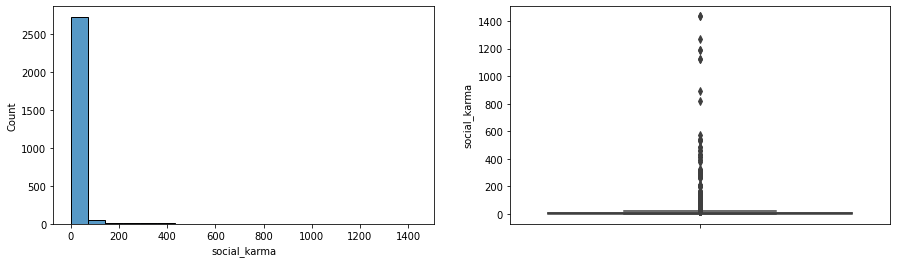

In [42]:
# try / except ....

fig, axs = plt.subplots(1,2,figsize=(15,4))

sns.histplot(x=features_post_VIF['social_karma'],ax=axs[0], bins=20)
sns.boxplot(y=features_post_VIF['social_karma'], ax=axs[1]);

In [43]:
#we decide to cap at 200 as not many observations above that value
features_post_VIF['social_karma_cap'] = features_post_VIF['social_karma'].apply(lambda x: 200 if x>200 else x)

/var/folders/f2/9xrxtpw920x5zr_wkns47k_h0000gn/T/ipykernel_19736/3047159839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_post_VIF['social_karma_cap'] = features_post_VIF['social_karma'].apply(lambda x: 200 if x>200 else x)


In [44]:
features_post_VIF['social_num_comments'].sort_values(ascending=False).head(20)
#we decide to cap at 200 as not many observations above that value

id
167      416
712      318
26737    318
12226    292
16802    292
838      287
17541    276
17624    259
727      178
7446     164
27972    158
22262    158
1637     135
1789     134
2330     131
30252    131
19691    123
2354     110
53650    110
70       107
Name: social_num_comments, dtype: int64

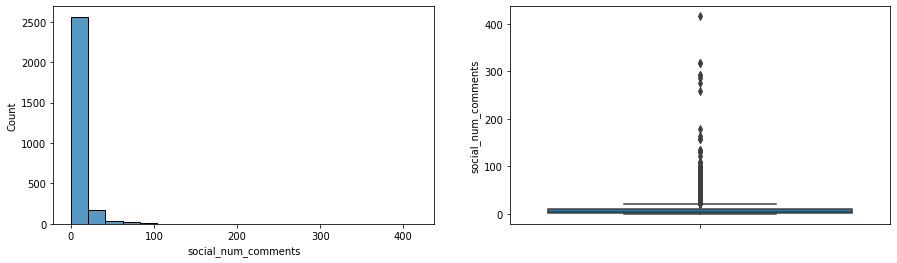

In [45]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

sns.histplot(x=features_post_VIF['social_num_comments'],ax=axs[0], bins=20)
sns.boxplot(y=features_post_VIF['social_num_comments'], ax=axs[1]);

In [46]:
features_post_VIF['social_num_comments_cap'] = features_post_VIF['social_num_comments'].apply(lambda x: 100 if x>100 else x)

/var/folders/f2/9xrxtpw920x5zr_wkns47k_h0000gn/T/ipykernel_19736/3118160077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_post_VIF['social_num_comments_cap'] = features_post_VIF['social_num_comments'].apply(lambda x: 100 if x>100 else x)


In [47]:
features_post_VIF.drop(columns=['social_karma' , 'social_num_comments'], inplace=True)

/var/folders/f2/9xrxtpw920x5zr_wkns47k_h0000gn/T/ipykernel_19736/2997674704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_post_VIF.drop(columns=['social_karma' , 'social_num_comments'], inplace=True)


In [48]:
features_post_VIF.columns

Index(['lex_liwc_OtherP', 'lex_liwc_death', 'lex_liwc_filler',
       'lex_liwc_nonflu', 'lex_liwc_QMark', 'lex_liwc_SemiC', 'lex_liwc_Colon',
       'lex_liwc_Dash', 'lex_liwc_home', 'lex_liwc_leisure', 'lex_liwc_money',
       'lex_liwc_swear', 'lex_liwc_friend', 'lex_liwc_number', 'lex_liwc_risk',
       'lex_liwc_sexual', 'lex_liwc_sad', 'lex_liwc_hear', 'lex_liwc_Comma',
       'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_reward',
       'lex_liwc_anx', 'lex_liwc_feel', 'lex_liwc_quant', 'lex_liwc_anger',
       'lex_liwc_certain', 'lex_liwc_discrep', 'lex_liwc_you', 'lex_liwc_we',
       'lex_liwc_cause', 'lex_liwc_ingest', 'lex_liwc_Period',
       'lex_liwc_Apostro', 'lex_liwc_percept', 'lex_liwc_negate',
       'lex_liwc_body', 'lex_liwc_female', 'lex_liwc_tentat', 'lex_liwc_Tone',
       'lex_liwc_focuspast', 'lex_liwc_male', 'lex_liwc_affiliation',
       'lex_liwc_insight', 'lex_liwc_Sixltr', 'lex_liwc_WC', 'lex_liwc_health',
       'lex_liwc_adverb', 'lex_liwc_differ

### Min Max Scalling 

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
scaler = MinMaxScaler()

In [51]:
X_scaled_array = scaler.fit_transform(features_post_VIF)

In [52]:
df_X_scaled = pd.DataFrame(columns = features_post_VIF.columns,
                           index = features_post_VIF.index,
                           data = X_scaled_array)

In [53]:
df_X_scaled.shape

(2833, 57)

In [54]:
smf_data = df_X_scaled.join(data['label'])

In [55]:
model_processed_data = smf_data

In [56]:
model_processed_data.to_csv('../dreaddit/data/model_processed_data.csv')

### Statsmodels

In [57]:
smf_log_reg_results = smf.ols(formula = 'label' + " ~ " +  " + ".join(smf_data.columns[:-1]), data=smf_data).fit().summary()

In [58]:
 smf_log_reg_results.tables[0]

Dep. Variable:,label,R-squared:,0.346
Model:,OLS,Adj. R-squared:,0.332
Method:,Least Squares,F-statistic:,25.72
Date:,"Tue, 01 Mar 2022",Prob (F-statistic):,3.39e-211
Time:,17:09:03,Log-Likelihood:,-1452.0
No. Observations:,2833,AIC:,3020.
Df Residuals:,2775,BIC:,3365.
Df Model:,57,,
Covariance Type:,nonrobust,,


In [59]:
 smf_log_reg_results.tables[2]

Omnibus:,295.862,Durbin-Watson:,1.986
Prob(Omnibus):,0.000,Jarque-Bera (JB):,89.094
Skew:,-0.105,Prob(JB):,4.50e-20
Kurtosis:,2.157,Cond. No.,82.6


In [60]:
results_as_html = smf_log_reg_results.tables[1].as_html()
smf_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
smf_results = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|')
smf_results

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7585,0.090,8.418,0.000,0.582,0.935
lex_liwc_WC,0.4422,0.091,4.861,0.000,0.264,0.621
lex_liwc_Sixltr,-0.4257,0.106,-4.003,0.000,-0.634,-0.217
lex_liwc_focuspast,-0.2717,0.058,-4.707,0.000,-0.385,-0.159
lex_liwc_Tone,-0.3122,0.030,-10.412,0.000,-0.371,-0.253
lex_liwc_female,-0.3104,0.052,-5.923,0.000,-0.413,-0.208
lex_liwc_article,-0.2724,0.052,-5.259,0.000,-0.374,-0.171
lex_liwc_feel,0.7138,0.128,5.564,0.000,0.462,0.965
lex_liwc_anx,0.6665,0.154,4.327,0.000,0.364,0.968
lex_liwc_you,-0.7658,0.107,-7.176,0.000,-0.975,-0.557


In [61]:
#smf_results.rename(index={'social_karma_cap':'social_karma'}, inplace=True)

In [62]:
sign_feat_list = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|').index
len(sign_feat_list[1:]) #exclude the intercept

31

In [63]:
sign_feat_list[1:]

Index(['lex_liwc_WC', 'lex_liwc_Sixltr', 'lex_liwc_focuspast', 'lex_liwc_Tone',
       'lex_liwc_female', 'lex_liwc_article', 'lex_liwc_feel', 'lex_liwc_anx',
       'lex_liwc_you', 'social_karma_cap', 'lex_liwc_Comma', 'lex_liwc_negate',
       'lex_liwc_compare', 'lex_liwc_ingest', 'lex_liwc_death',
       'lex_liwc_differ', 'lex_liwc_percept', 'lex_liwc_Apostro',
       'lex_liwc_home', 'lex_liwc_QMark', 'lex_liwc_we', 'lex_liwc_risk',
       'lex_liwc_male', 'lex_liwc_sad', 'lex_liwc_swear', 'lex_liwc_leisure',
       'lex_liwc_anger', 'lex_liwc_number', 'lex_liwc_quant',
       'lex_liwc_health', 'lex_liwc_adverb'],
      dtype='object')

In [64]:
# fig, axs = plt.subplots(nrows=5,ncols=5,figsize=(60,60) )
# #pal = sns.color_palette(palette=None, n_colors=len(sign_feat_list[1:]))

# for (i,f,c) in zip(axs.flatten(),sign_feat_list[1:], pal):
#     sns.histplot(ax=i, hue=data['label'], x=data[f], element="step",  )

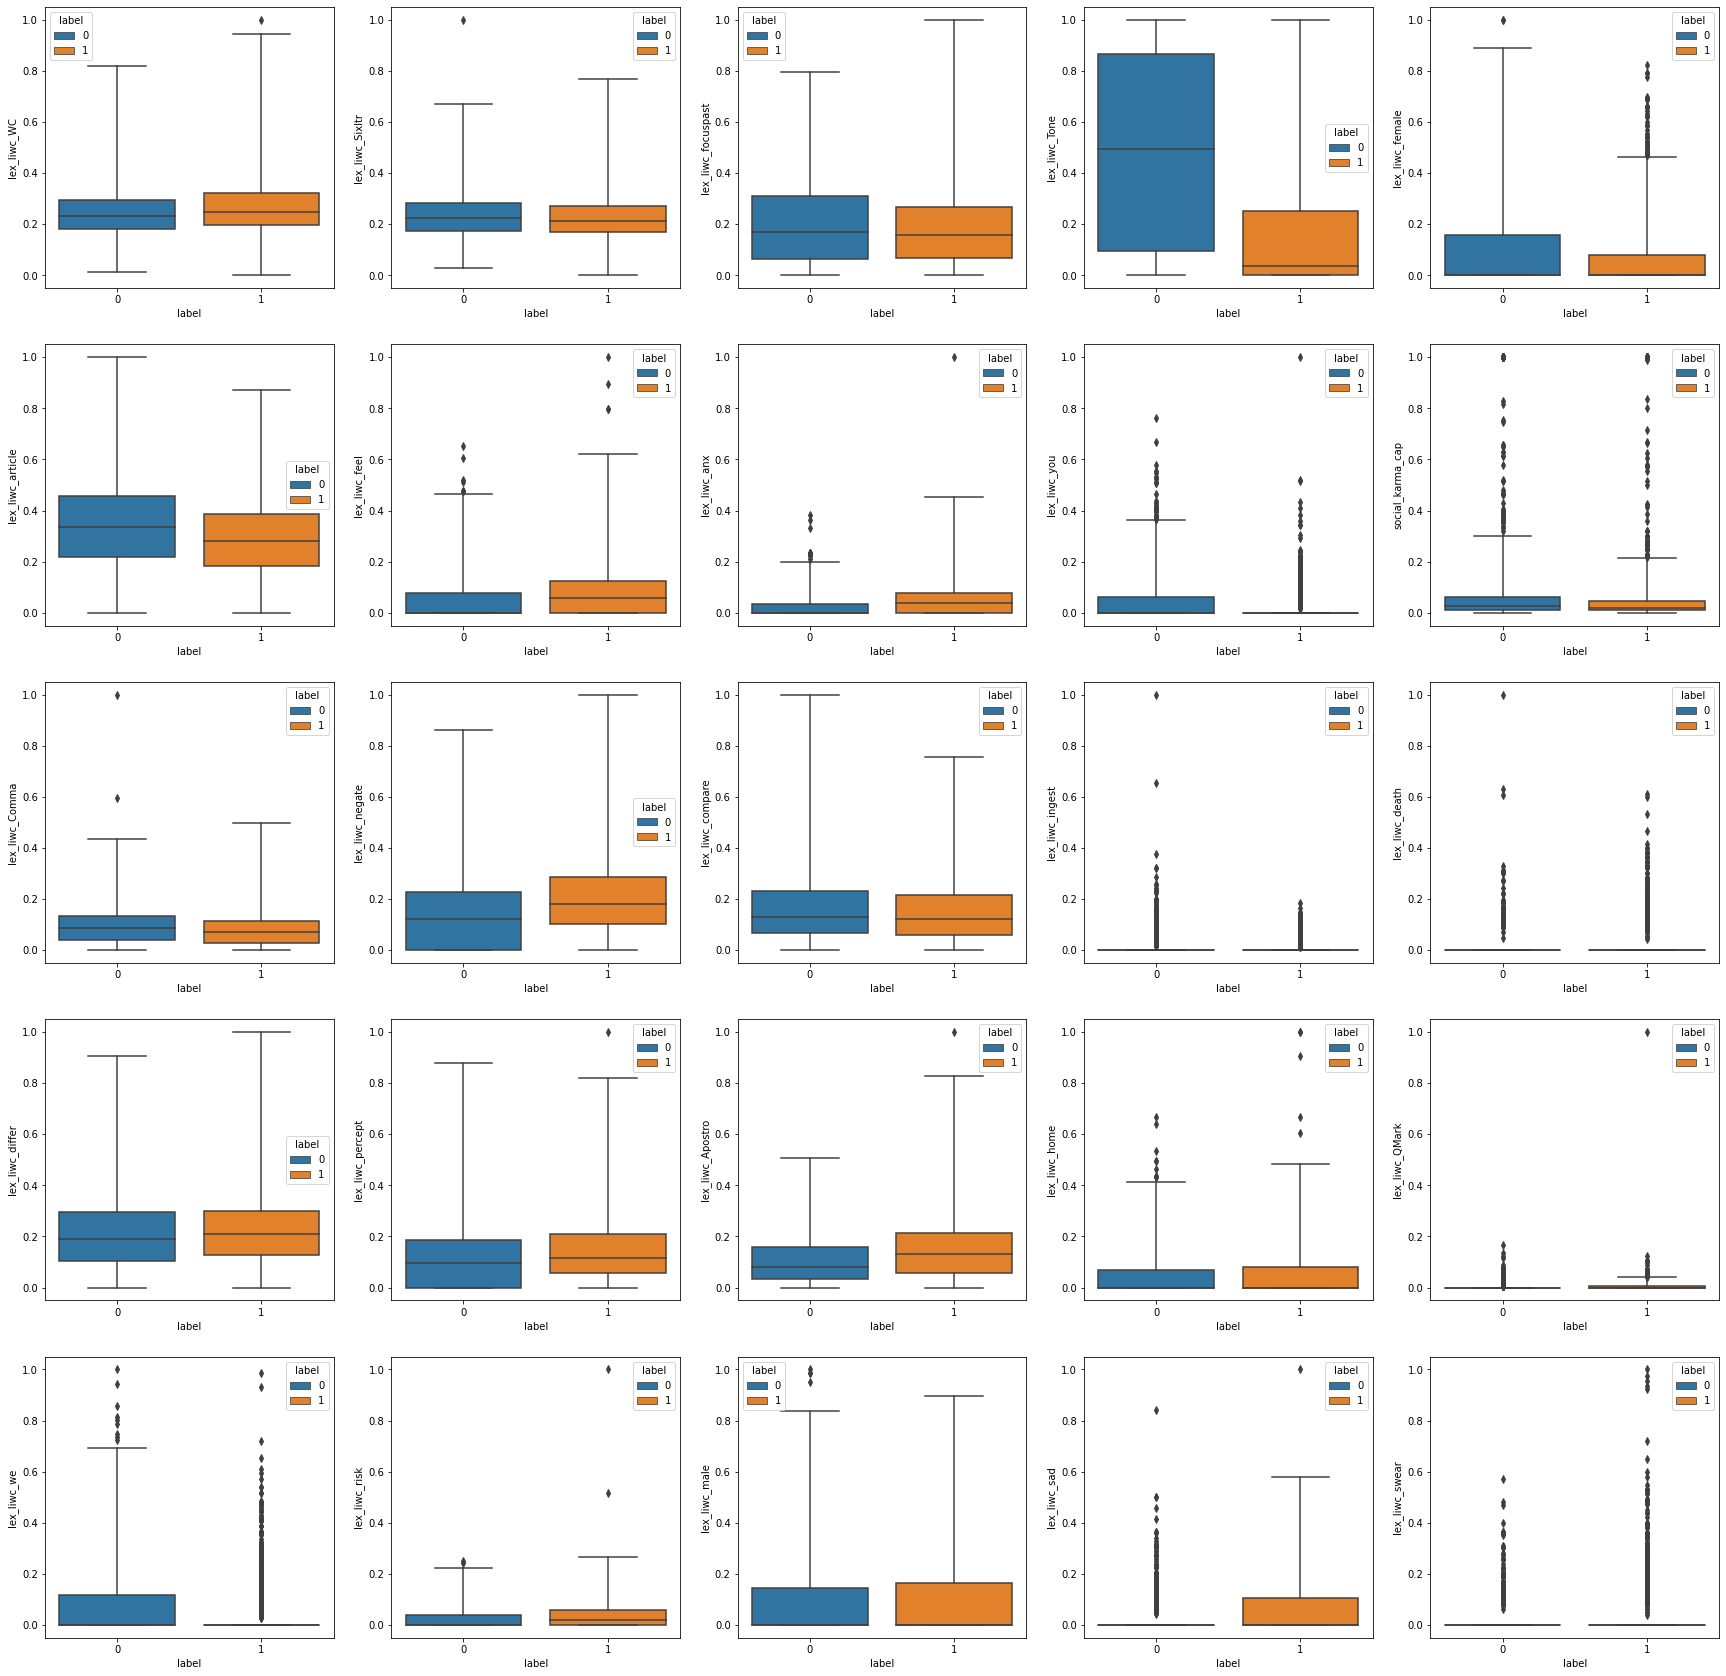

In [65]:
fig, axs = plt.subplots(nrows=5,ncols=5,figsize=(30,30) )
#pal = sns.color_palette(palette=None, n_colors=len(sign_feat_list[1:]))

for (i,f) in zip(axs.flatten(),sign_feat_list[1:]):
    sns.boxplot(ax=i, hue=smf_data['label'], x=smf_data['label'], y=smf_data[f], whis=5, dodge=False )

In [66]:
stressed = data.loc[data['label']==1]['text']
non_stressed = data.loc[data['label']==0]['text']

In [67]:
stressed_corpus = " ".join(["".join(i) for i in stressed])
non_stressed_corpus = " ".join(["".join(i) for i in non_stressed])

In [68]:
from wordcloud import WordCloud, STOPWORDS

In [69]:
wordcloud_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(stressed_corpus)
wordcloud_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(non_stressed_corpus)

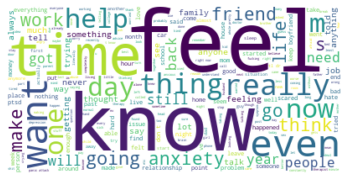

In [70]:
plt.imshow(wordcloud_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()

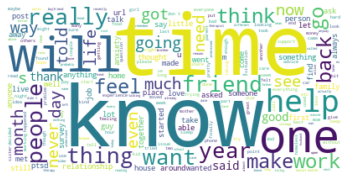

In [71]:
plt.imshow(wordcloud_non_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()

In [72]:
ptsd = data.loc[data['domain']=='ptsd']['text']
ﬁnancial = data.loc[data['domain']=='ﬁnancial']['text']
anxiety = data.loc[data['domain']=='anxiety']['text']
abuse = data.loc[data['domain']=='abuse']['text']
social = data.loc[data['domain']=='social']['text']

In [73]:
ptsd_corpus = " ".join(["".join(i) for i in ptsd])
ﬁnancial_corpus = " ".join(["".join(i) for i in ﬁnancial])
anxiety_corpus = " ".join(["".join(i) for i in anxiety])
abuse_corpus = " ".join(["".join(i) for i in abuse])
social_corpus = " ".join(["".join(i) for i in social])

In [74]:
wordcloud_ptsd = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ptsd_corpus)
wordcloud_ﬁnancial = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ﬁnancial_corpus)
wordcloud_anxiety = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(anxiety_corpus)
wordcloud_abuse = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(abuse_corpus)
wordcloud_social = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(social_corpus)


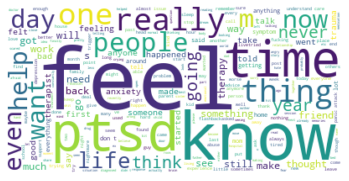

In [75]:
plt.imshow(wordcloud_ptsd, interpolation='bilinear')
plt.axis("off")
plt.show()

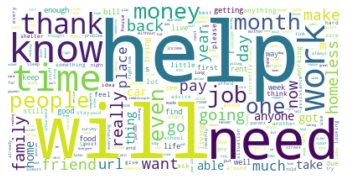

In [76]:
plt.imshow(wordcloud_ﬁnancial, interpolation='bilinear')
plt.axis("off")
plt.show()

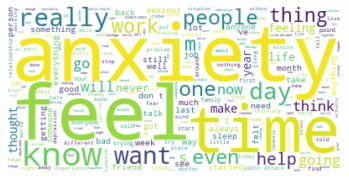

In [77]:
plt.imshow(wordcloud_anxiety , interpolation='bilinear')
plt.axis("off")
plt.show()

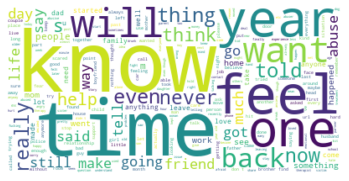

In [78]:
plt.imshow(wordcloud_abuse , interpolation='bilinear')
plt.axis("off")
plt.show()

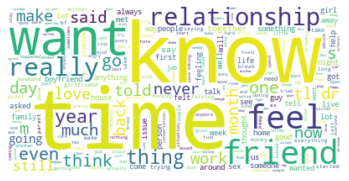

In [79]:
plt.imshow(wordcloud_social , interpolation='bilinear')
plt.axis("off")
plt.show()

### Pre-processing the test data set

In [80]:
data_test = pd.read_csv('../raw_data/dreaddit-test.csv', parse_dates=True)
data_test.set_index(['id'], inplace=True)
data_test_label = data_test[['label']]

In [81]:
data_test.drop(columns=cols_to_remove, inplace=True)

data_test['domain'] = data_test['subreddit'].map({'domesticviolence': 'abuse',
                                                   'survivorsofabuse': 'abuse',
                                                   'anxiety': 'anxiety',
                                                   'stress': 'anxiety',
                                                   'almosthomeless': 'ﬁnancial',
                                                   'assistance': 'ﬁnancial',
                                                   'food_pantry': 'ﬁnancial',
                                                   'homeless':'ﬁnancial',
                                                   'ptsd':'ptsd',
                                                   'relationships':'social'
                                                   })

data_test['social_date'] = data_test['social_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_test = data_test.drop(columns='social_timestamp')

data_test['pct_caps'] = data_test['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x) )
data_test['text'] = data_test['text'].apply(lambda x: x.lower())

In [82]:
#mapping the domain to the test set
data_test['domain_label'] = data_test['domain'].map({'ptsd':1,
                                           'ﬁnancial':2,
                                           'social':3,
                                           'abuse':4,
                                           'anxiety':5
                                            })

In [83]:
data_test.drop(columns=['text','subreddit','domain'], inplace=True)
data_test.drop(columns=['label','domain_label','confidence', 'sentence_range','social_date' ], inplace=True)

data_test['social_karma_cap'] = data_test['social_karma'].apply(lambda x: 200 if x>200 else x)
data_test['social_num_comments_cap'] = data_test['social_num_comments'].apply(lambda x: 100 if x>100 else x)

In [84]:
data_test = data_test[features_post_VIF.columns]

In [85]:
X_test_scaled_array = scaler.transform(data_test)

In [86]:
df_X_scaled_test = pd.DataFrame(columns = data_test.columns,
                                index = data_test.index,
                                data = X_test_scaled_array)

In [87]:
df_X_scaled_test.shape

(715, 57)

In [88]:
model_processed_data_test =  df_X_scaled_test.join(data_test_label)

In [89]:
model_processed_data_test.to_csv('../dreaddit/data/model_processed_data_test.csv')

### Testing various ML models

In [90]:
#Train and test data set 

X_train = model_processed_data.copy()
y_train = X_train.pop('label')

X_test = model_processed_data_test.copy()
y_test = X_test.pop('label')

### Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
log_model = LogisticRegression(max_iter=1_000)

In [92]:
y_pred = log_model.fit(X_train,y_train).predict(X_test)

In [93]:
log_model.score(X_test,y_test)

0.737062937062937

In [94]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
grid_log_reg = {'penalty': ['none'], #['l1', 'l2', 'elasticnet', 'none'],
                'C':[0, 0.0001, 0.01, 1, 10, 100, 1000],
                'solver':['newton-cg', 'newton-cg', 'lbfgs'] }  #, 'sag', 'saga']}

log_search = RandomizedSearchCV(log_model, grid_log_reg, n_jobs=-1, cv=10, verbose=0, scoring='accuracy' )
log_search.fit(X_train,y_train, sample_weight = data['confidence']) 

/Users/radulradulov/.pyenv/versions/3.8.12/envs/dreaddit/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
                   n_jobs=-1,
                   param_distributions={'C': [0, 0.0001, 0.01, 1, 10, 100,
                                              1000],
                                        'penalty': ['none'],
                                        'solver': ['newton-cg', 'newton-cg',
                                                   'lbfgs']},
                   scoring='accuracy')

In [95]:
log_search.best_estimator_

LogisticRegression(C=0.0001, max_iter=1000, penalty='none', solver='newton-cg')

In [96]:
log_search.best_score_

0.7529139501318867

In [97]:
log_search.score(X_test, y_test)

0.7412587412587412

In [98]:
#Best model from the Grid Search
#LogisticRegression(C=1e-05, max_iter=1000, penalty='none', solver='newton-cg')
#0.7580419580419581

In [99]:
# from sklearn.feature_selection import SequentialFeatureSelector
# selector = SequentialFeatureSelector(LogisticRegression(max_iter=1_000), cv=10, n_jobs=-1, direction='backward',
#                                     n_features_to_select=0.6)
# selector.fit(X_train, y_train)
# selector.transform(X_train)
# len(selector.get_feature_names_out())
# X_train_selected = pd.DataFrame(columns = selector.get_feature_names_out(),
#                                 index = X_train.index,
#                                 data = selector.transform(X_train))
# X_test_selected = X_test[selector.get_feature_names_out()]

### SVC

In [100]:
from sklearn.svm import SVC

SVC_model = SVC()

gird_SVC = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'C':stats.uniform(0.01,10),
            'gamma':stats.loguniform(0.01,10)}

In [101]:
SVC_search = RandomizedSearchCV(SVC_model, gird_SVC, n_jobs=-1, cv=10, verbose=0, scoring='accuracy')
SVC_search.fit(X_train,y_train, sample_weight = data['confidence']) 

RandomizedSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x126b48490>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x126d16f10>,
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='accuracy')

In [102]:
SVC_search.best_estimator_

SVC(C=5.984449969660414, gamma=0.44611276536592476, kernel='linear')

In [103]:
SVC_search.best_score_

0.7483252874135271

In [104]:
SVC_search.score(X_test, y_test)

0.7440559440559441

### KNN

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
knn_model = KNeighborsClassifier()
grid_knn = {'n_neighbors':[2,3,4,5,6,7,8,9,10,12,15,20,25]}

In [107]:
knn_search =  RandomizedSearchCV(knn_model, grid_knn, cv=10, scoring='accuracy', verbose=1 )

In [108]:
knn_search.fit(X_train,y_train) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9,
                                                        10, 12, 15, 20, 25]},
                   scoring='accuracy', verbose=1)

In [109]:
knn_search.best_estimator_

KNeighborsClassifier(n_neighbors=20)

In [110]:
knn_search.best_score_

0.7221768775195343

In [111]:
knn_search.score(X_test, y_test)

0.7314685314685314

### XGBoost

In [112]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(use_label_encoder=False) #eval_metric='error')

/Users/radulradulov/.pyenv/versions/3.8.12/envs/dreaddit/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [113]:
grid_xgboost = {'n_estimators':range(10,300,10) ,
                'max_depth':[2,4,6,8,10,12,14,16,18,20],
                'learning_rate': stats.loguniform(0.01,0.5),
                'booster':['gbtree', 'gblinear', 'dart']
               }

search_xgboost = RandomizedSearchCV(model_xgb, grid_xgboost, cv=5,
                                    scoring='accuracy', verbose=1,n_jobs=-1)



In [114]:
search_xgboost.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[17:10:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:10:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/radulradulov/.pyenv/versions/3.8.12/envs/dreaddit/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False,
                                    

In [115]:
search_xgboost.best_score_

0.7472656907285883

In [116]:
search_xgboost.best_estimator_

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=-1,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.18869527388258292, max_delta_step=None,
              max_depth=16, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=90, n_jobs=8,
              num_parallel_tree=None, predictor=None, random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
              tree_method=None, use_label_encoder=False, validate_parameters=1,
              verbosity=None)

In [117]:
search_xgboost.score(X_test, y_test)

0.7356643356643356

### AdaBoost

In [118]:
from sklearn.ensemble import AdaBoostClassifier  #,GradientBoostingClassifier
ada_model = AdaBoostClassifier() #searching of the best estimator

In [119]:
gird_ada = {'base_estimator':[LogisticRegression()],  # GradientBoostingClassifier()],
            'learning_rate': stats.loguniform(0.01,0.5)}

In [120]:
search_ada = RandomizedSearchCV(ada_model, gird_ada, cv=10, scoring='accuracy', verbose=0 )

In [121]:
search_ada.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=AdaBoostClassifier(),
                   param_distributions={'base_estimator': [LogisticRegression()],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x127300b80>},
                   scoring='accuracy')

In [122]:
search_ada.best_score_

0.714780022893545

In [123]:
search_ada.best_estimator_

AdaBoostClassifier(base_estimator=LogisticRegression(),
                   learning_rate=0.42071701013600865)

In [124]:
search_ada.score(X_test, y_test)

0.7328671328671329

In [125]:
search_ada.score(X_test, y_test)

0.7328671328671329

### Gradient Boosting

In [126]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()


In [127]:
gird_gb = {'n_estimators':range(10,300,10),
           'learning_rate': stats.loguniform(0.01,0.5)}

In [128]:
search_gb = RandomizedSearchCV(gb_model, gird_gb, cv=10, scoring='accuracy', verbose=1, n_jobs=-1, refit=True )

In [129]:
search_gb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x123d14e50>,
                                        'n_estimators': range(10, 300, 10)},
                   scoring='accuracy', verbose=1)

In [130]:
search_gb.best_score_

0.7405564126810332

In [131]:
search_gb.best_estimator_

GradientBoostingClassifier(learning_rate=0.06441243988476167, n_estimators=60)

In [132]:
search_gb.score(X_test, y_test)

0.7580419580419581

### Stacking Classifiers

In [150]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

ensamble = StackingClassifier( 
    estimators=[('log_reg',log_search.best_estimator_), 
                ('svc', SVC_search.best_estimator_), 
                ('gb', search_gb.best_estimator_)], n_jobs=-1)
    

In [151]:
from sklearn.model_selection import cross_val_score
ensamble_score = cross_val_score(ensamble, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

In [152]:
ensamble_score.mean()

0.747266460956552

In [153]:
ensamble.fit(X_train, y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(C=0.0001, max_iter=1000,
                                                   penalty='none',
                                                   solver='newton-cg')),
                               ('svc',
                                SVC(C=5.984449969660414,
                                    gamma=0.44611276536592476,
                                    kernel='linear')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.06441243988476167,
                                                           n_estimators=60))],
                   n_jobs=-1)

In [154]:
ensamble.score(X_test, y_test)

0.7482517482517482

In [155]:
from sklearn.ensemble import BaggingClassifier

weak_learner = LogisticRegression() #log_search.best_estimator_
bagged_model = BaggingClassifier(weak_learner, n_estimators=30, verbose=0)

bagged_model.fit(X_train, y_train)
bagged_model.score(X_test, y_test)

0.7356643356643356